<a href="https://colab.research.google.com/github/laurencecao/Apollo-11/blob/master/DQN_(LunarLander_v2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install necessary packages

In [ ]:
!pip install numpy torch gym box2d-py

Import necessary packages

In [1]:
import random
import numpy as np

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Select Device

In [2]:
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")

if T.cuda.is_available():
    print(f'Running on {T.cuda.get_device_name(0)}')
else:
    print('Running on CPU')

Running on NVIDIA L4


The Neural Network (Q values)

In [3]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F


class QNetwork(nn.Module):
    """ Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_unit=64,
                 fc2_unit=64):
        """
        Initialize parameters and build model.
        Params
        =======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_unit (int): Number of nodes in first hidden layer
            fc2_unit (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()  # calls __init__ method of nn.Module class
        self.seed = T.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_unit)
        self.fc2 = nn.Linear(fc1_unit, fc2_unit)
        self.fc3 = nn.Linear(fc2_unit, action_size)

    def forward(self, x):
        # x = state
        """
        Build a network that maps state -> action values.
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


Experience Replay

In [4]:
from collections import deque, namedtuple

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = T.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = T.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = T.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = T.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(
            device)
        dones = T.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Agent class to put it all together

In [5]:
# hyper parameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64  # minibatch size
GAMMA = 0.99  # discount factor
TAU = 1e-3  # for soft update of target parameters
LR = 5e-4  # learning rate
UPDATE_EVERY = 4  # how often to update the network


class Agent:
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        random.seed(seed)
        self.state_size = state_size
        self.action_size = action_size

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = T.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with T.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        q_targets = rewards + (gamma * q_targets_next * (1 - dones))

        # Get expected Q values from local model
        q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(q_expected, q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


The training loop

In [11]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []  # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start  # initialize epsilon
    for i_episode in range(1, n_episodes + 1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            if isinstance(state, tuple):
              state = state[0]
            action = agent.act(state, eps)
            next_state, reward, done, truncated, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score
        eps = max(eps_end, eps_decay * eps)  # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100,
                                                                                         np.mean(scores_window)))
            T.save(agent.qnetwork_local.state_dict(), 'data.pth')
            break
    return scores


In [12]:
import gym

# initialize environment
env = gym.make('LunarLander-v2')
# env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

# initialize agent
agent = Agent(state_size=8, action_size=4, seed=0)

# run the training session
scores = dqn()

State shape:  (8,)
Number of actions:  4


/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: -188.23
Episode 200	Average Score: -134.95
Episode 300	Average Score: -70.04
Episode 400	Average Score: 5.51
Episode 500	Average Score: 36.89
Episode 600	Average Score: 79.99
Episode 700	Average Score: 169.98
Episode 800	Average Score: 177.46
Episode 851	Average Score: 200.22
Environment solved in 751 episodes!	Average Score: 200.22


Plot the rewards

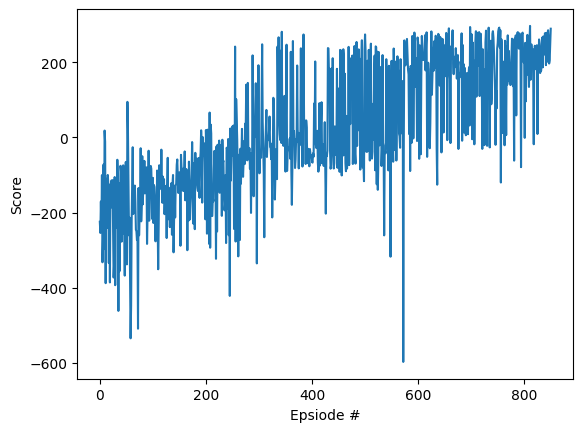

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Epsiode #')
plt.show()